In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
import pickle


import warnings
warnings.filterwarnings(action='ignore') 

# 사이킷런
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 회귀
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
pd.set_option('display.max_row', 5000)
pd.set_option('display.max_columns', 100)

from matplotlib import font_manager, rc
import matplotlib
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()

rc('font', family=font_name)

matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
dir='C:\\농업기술원\\1차\\2019\\19-20_방울토마토(4)\\19-20_방울토마토_아리울_박문신(재배기간_2019.07.23~2020.06.30)/'
sang_data1 = pd.read_excel(dir+'19-20작기_방울토마토_아리울_박문신_생육1.xlsx')
sang_data2 = pd.read_excel(dir+'19-20작기_방울토마토_아리울_박문신_생육2.xlsx')
harvest_data1 = pd.read_excel(dir+'19-20작기_방울토마토_아리울_박문신_생육1.xlsx',sheet_name='수확과')
harvest_data2 = pd.read_excel(dir+'19-20작기_방울토마토_아리울_박문신_생육2.xlsx',sheet_name='수확과')
env_data = pd.read_excel(dir+'19-20작기_방울토마토_아리울_박문신_환경(2019.07.23~2020.06.30).xlsx')
yang_data = pd.read_excel(dir+'19-20작기_방울토마토_아리울_박문신_양액(2019.07.23~2020.06.30).xlsx')

In [4]:
env_data=env_data[['date', '내부온도', '내부습도','CO2','누적일사량']]

# 생육에 주차 추가

In [5]:
# 주차 추가
def add_weeknum(sang_df):
    sang_df['diff']=sang_df['WeekNum'].shift(1)
    sang_df['diff2']=sang_df['WeekNum']-sang_df['diff']
    
    num=-1
    test_week=[]
    for i in range(len(sang_df)):
        if sang_df['diff2'].loc[i]!=0:
            num+=1
            test_week.append(num)
        else:
            test_week.append(num)
    del sang_df['diff']
    del sang_df['diff2']
    return test_week

In [6]:
sang_data1['주차']=add_weeknum(sang_data1)
sang_data2['주차']=add_weeknum(sang_data2)

In [7]:
sang_data1=sang_data1[['Date','Sample','주차','생장길이']]
sang_data2=sang_data2[['Date','Sample','주차','생장길이']]

# 생육 이상치 제거 (선택에 따라 이 과정 안하고 넘어가도 됨) 

In [8]:
q1 = sang_data1['생장길이'].quantile(0.25)
q3 = sang_data1['생장길이'].quantile(0.75)

iqt = 1.5 * (q3 - q1)

# 이상치 제거

sang_data_delout1=sang_data1[(sang_data1['생장길이'] < (q3 + iqt)) & (sang_data1['생장길이'] > (q1 - iqt))]




In [9]:
q1 = sang_data2['생장길이'].quantile(0.25)
q3 = sang_data2['생장길이'].quantile(0.75)

iqt = 1.5 * (q3 - q1)

# 이상치 제거

sang_data_delout2=sang_data2[(sang_data2['생장길이'] < (q3 + iqt)) & (sang_data2['생장길이'] > (q1 - iqt))]

# 환경 12시간 단위로 끊기

In [10]:
# 12시간 짤라서 Date 추가
def env_add_Date(env_df,생육조사기간):
    df=pd.DataFrame()
    for i in range(len(생육조사기간)-1):
        start_i = 생육조사기간[i]+timedelta(hours=12)
        end_i = 생육조사기간[i+1]+timedelta(hours=12)

        df2 = env_df[(env_df['date']>=start_i) & (env_df['date']<end_i)]
        df2['Date']=생육조사기간[i+1]


        df=pd.concat([df,df2])
    return df

In [11]:
생육조사기간=sorted(list(set(list(sang_data1['Date']))))
env_data1=env_add_Date(env_data,생육조사기간)

In [12]:
생육조사기간=sorted(list(set(list(sang_data2['Date']))))
env_data2=env_add_Date(env_data,생육조사기간)

# 환경날짜와 측정 날짜의 차이를 구함

In [13]:
env_data1['n_date']=env_data1['date'].apply(lambda x : x.strftime('%Y-%m-%d'))
env_data2['n_date']=env_data2['date'].apply(lambda x : x.strftime('%Y-%m-%d'))

In [14]:
def n_date(d):
    myDatetimeStr = d
    myDatetime = datetime.strptime(myDatetimeStr, '%Y-%m-%d')
    return myDatetime

In [15]:
env_data1['n_date']=env_data1['n_date'].apply(n_date)
env_data2['n_date']=env_data2['n_date'].apply(n_date)

In [16]:
env_data1['diff']=env_data1['Date']-env_data1['n_date']
env_data2['diff']=env_data2['Date']-env_data2['n_date']

In [17]:
env_data1.head(10)

,date,내부온도,내부습도,CO2,누적일사량,Date,n_date,diff
4464,2019-08-07 12:00:00,37.9,54,295,549.5,2019-08-13,2019-08-07,6 days
4465,2019-08-07 12:05:00,38.8,54,289,569.7,2019-08-13,2019-08-07,6 days
4466,2019-08-07 12:10:00,39.0,54,287,590.3,2019-08-13,2019-08-07,6 days
4467,2019-08-07 12:15:00,39.2,53,286,611.1,2019-08-13,2019-08-07,6 days
4468,2019-08-07 12:20:00,39.6,52,285,631.6,2019-08-13,2019-08-07,6 days
4469,2019-08-07 12:25:00,39.5,51,281,652.4,2019-08-13,2019-08-07,6 days
4470,2019-08-07 12:30:00,39.8,50,281,674.6,2019-08-13,2019-08-07,6 days
4471,2019-08-07 12:35:00,39.5,51,280,689.5,2019-08-13,2019-08-07,6 days
4472,2019-08-07 12:40:00,39.1,53,285,701.6,2019-08-13,2019-08-07,6 days
4473,2019-08-07 12:45:00,38.5,55,285,713.2,2019-08-13,2019-08-07,6 days


In [18]:
env_data2.head(10)

,date,내부온도,내부습도,CO2,누적일사량,Date,n_date,diff
44208,2019-12-23 12:00:00,21.3,76,458,283.9,2019-12-30,2019-12-23,7 days
44209,2019-12-23 12:05:00,22.1,75,452,297.3,2019-12-30,2019-12-23,7 days
44210,2019-12-23 12:10:00,22.6,72,447,312.0,2019-12-30,2019-12-23,7 days
44211,2019-12-23 12:15:00,22.5,69,440,326.5,2019-12-30,2019-12-23,7 days
44212,2019-12-23 12:20:00,21.9,68,441,336.1,2019-12-30,2019-12-23,7 days
44213,2019-12-23 12:25:00,20.9,69,441,342.4,2019-12-30,2019-12-23,7 days
44214,2019-12-23 12:30:00,22.0,70,434,353.8,2019-12-30,2019-12-23,7 days
44215,2019-12-23 12:35:00,22.5,72,436,360.7,2019-12-30,2019-12-23,7 days
44216,2019-12-23 12:40:00,21.4,71,440,368.5,2019-12-30,2019-12-23,7 days
44217,2019-12-23 12:45:00,20.7,68,445,380.5,2019-12-30,2019-12-23,7 days


# 일사량 해결

In [19]:
def cumsum_to_value(df):
    #누적일사량 해결
    df['lag_누적일사량']=df['누적일사량'].shift(1)
    df['일사량2']=df['누적일사량']-df['lag_누적일사량']

    #음수를 0으로 치환 NA를 0으로 치환
    df['일사량2_치환']=df['일사량2'].apply(lambda x : 0 if x<0 else x)
    df['일사량']=df['일사량2_치환'].fillna(0)

    del df['lag_누적일사량']
    del df['일사량2']
    del df['일사량2_치환']
    return df

In [20]:
base_col=['date','Date']
cumsum_list=['누적일사량']
cumsum_col=base_col+cumsum_list

In [21]:
cumsum_df1=cumsum_to_value(env_data1[cumsum_col])
env_data1['일사량']=cumsum_df1['일사량']
del env_data1['누적일사량']

In [22]:
cumsum_df2=cumsum_to_value(env_data2[cumsum_col])
env_data2['일사량']=cumsum_df2['일사량']
del env_data2['누적일사량']

# 환경 주차 생성

In [23]:
# 생육 Date와 환경 Date 매칭
def match_test_weeknum(sang_data,env_data):
    dic=dict(zip(sang_data['Date'],sang_data['주차']))
    result=env_data.replace({"Date":dic})["Date"]
    return result

In [24]:
env_data1['주차']=match_test_weeknum(sang_data1,env_data1)
env_data2['주차']=match_test_weeknum(sang_data2,env_data2)

In [25]:
env_data2

,date,내부온도,내부습도,CO2,Date,n_date,diff,일사량,주차
44208,2019-12-23 12:00:00,21.3,76,458,2019-12-30,2019-12-23,7 days,0.0,1
44209,2019-12-23 12:05:00,22.1,75,452,2019-12-30,2019-12-23,7 days,13.4,1
44210,2019-12-23 12:10:00,22.6,72,447,2019-12-30,2019-12-23,7 days,14.7,1
44211,2019-12-23 12:15:00,22.5,69,440,2019-12-30,2019-12-23,7 days,14.5,1
44212,2019-12-23 12:20:00,21.9,68,441,2019-12-30,2019-12-23,7 days,9.6,1
...,...,...,...,...,...,...,...,...,...
98635,2020-06-29 11:35:00,27.9,76,372,2020-06-29,2020-06-29,0 days,7.8,27
98636,2020-06-29 11:40:00,27.9,76,367,2020-06-29,2020-06-29,0 days,8.2,27
98637,2020-06-29 11:45:00,28.2,76,362,2020-06-29,2020-06-29,0 days,8.9,27
98638,2020-06-29 11:50:00,28.6,75,363,2020-06-29,2020-06-29,0 days,10.3,27


# 환경 pivot

In [26]:
def remove_outlier_pivot(df,col,aggfunc):
    cut_df=pd.DataFrame()
    for i in range(len(df['주차'].unique())):
        k=df[df['주차']==i+1]
        
        
        q1 = k[col].quantile(0.25)
        q3 = k[col].quantile(0.75)

        iqt = 1.5 * (q3 - q1)

        # 이상치 제거
        if iqt!=0:
            k=k[(k[col] < (q3 + iqt)) & (k[col] > (q1 - iqt))]
        
        cut_df=pd.concat([cut_df,k])

    result = cut_df.pivot_table(index=['주차'],
                               values=col,
                               aggfunc=aggfunc).reset_index(drop=False)

    return result

In [27]:
# 평균으로 집계할 변수와, 합으로 집계할 변수 설정하기
base_col=['date','Date','주차','diff']
avg_list=['내부온도','내부습도','CO2']
sum_list=['일사량']
cols=avg_list+sum_list
aggfunc=['mean']*len(avg_list)+['sum']*len(sum_list)

In [28]:
i=0
for col,agg in zip(cols,aggfunc):
    df=env_data1[[col,'n_date','주차']]

    # 이상치 제거, 피봇
    my_pivot = remove_outlier_pivot(df,col,agg)
    
    if i==0:
        result1 = my_pivot
        i+=1
        continue

    result1 = pd.merge(result1,my_pivot,how='inner',on='주차')

In [29]:
i=0
for col,agg in zip(cols,aggfunc):
    df=env_data2[[col,'주차']]

    # 이상치 제거, 피봇
    my_pivot = remove_outlier_pivot(df,col,agg)
    
    if i==0:
        result2 = my_pivot
        i+=1
        continue

    result2 = pd.merge(result2,my_pivot,how='inner',on='주차')

In [30]:
result1.head(5)

,주차,내부온도,내부습도,CO2,일사량
0,1,32.113484,73.962384,363.309606,9842.1
1,2,29.921131,80.302083,375.036072,11912.0
2,3,27.740427,80.161706,409.793155,10149.5
3,4,25.109201,83.681134,425.112847,6559.8
4,5,25.873094,90.706793,389.284788,4588.0


In [31]:
result2.head(5)

,주차,내부온도,내부습도,CO2,일사량
0,1,16.069524,81.131308,585.065476,852.2
1,2,16.262437,84.701460,560.892857,2196.2
2,3,15.677447,88.345107,535.620398,313.0
3,4,16.264774,88.101498,565.979663,3417.4
4,5,15.647929,89.454089,542.855035,1116.3


# 생육+환경

In [32]:
# 생육과 환경조인
sang_env1 = pd.merge(sang_data_delout1,result1,on='주차',how='inner')
sang_env2 = pd.merge(sang_data_delout2,result2,on='주차',how='inner')

In [33]:
def 이중축그래프(data,x,y,title,hue="Sample"):
    fig, ax0=plt.subplots(figsize=(15,7))

    ax1 = ax0.twinx()
    sns.lineplot(data=data,
                y=y,
                x='Date',
                hue=hue,ax=ax0)
    sns.lineplot(data=data,
                y=x,
                x='Date',ax=ax1,color='green')
    plt.title(title)
    plt.plot()

<Figure size 1080x720 with 0 Axes>

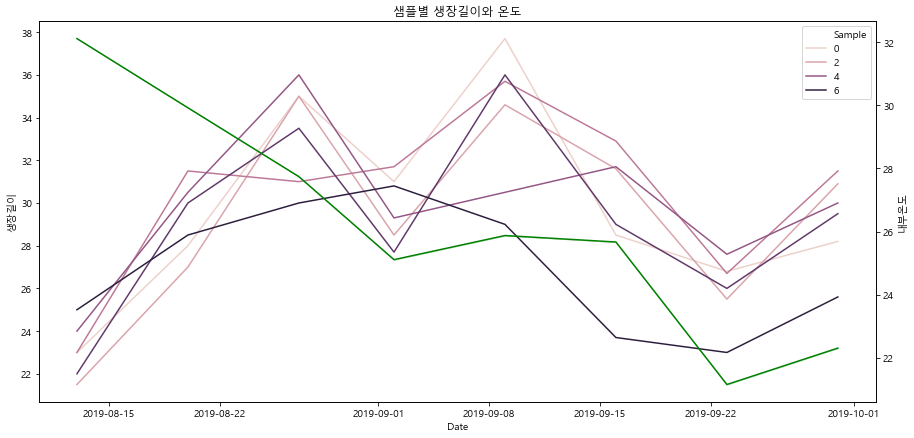

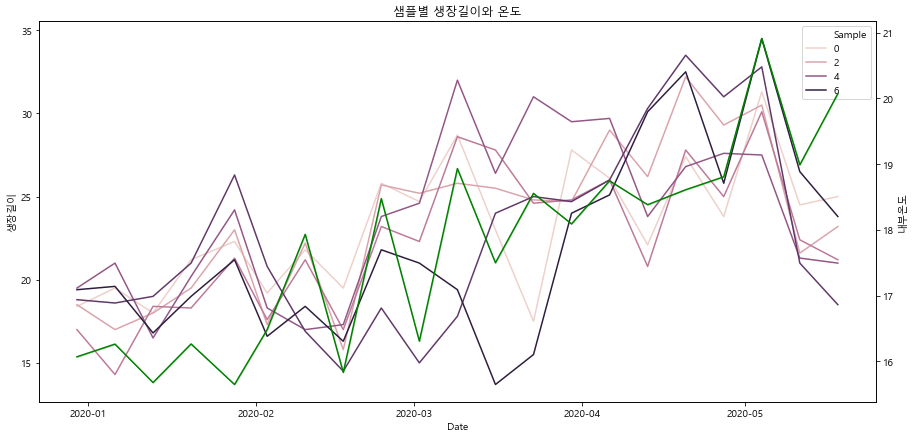

In [34]:
plt.figure(figsize=(15,10))
이중축그래프(data=sang_env1,x='내부온도',y='생장길이',
      title='샘플별 생장길이와 온도')
이중축그래프(data=sang_env2,x='내부온도',y='생장길이',
      title='샘플별 생장길이와 온도')
plt.show()

<Figure size 1080x720 with 0 Axes>

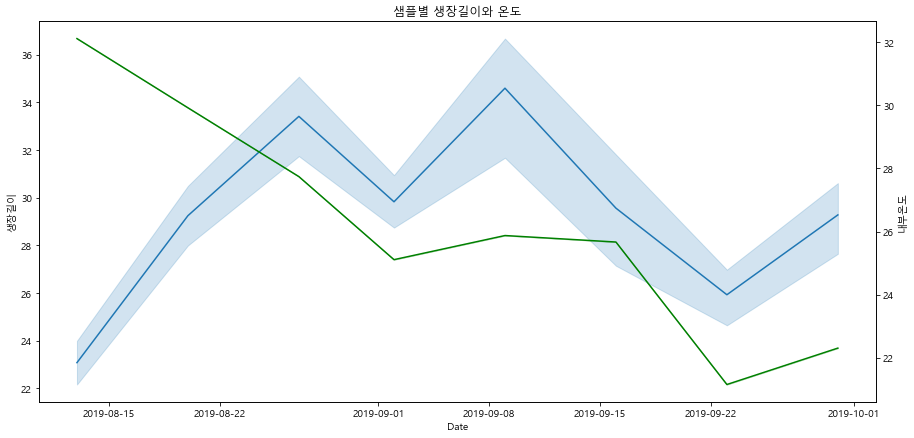

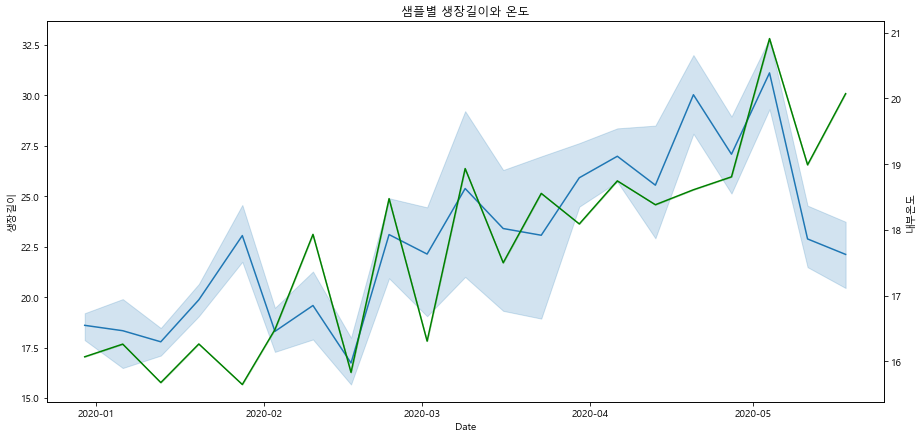

In [35]:
plt.figure(figsize=(15,10))
이중축그래프(data=sang_env1,x='내부온도',y='생장길이', hue=None,
      title='샘플별 생장길이와 온도')

이중축그래프(data=sang_env2,x='내부온도',y='생장길이', hue=None,
      title='샘플별 생장길이와 온도')
plt.show()

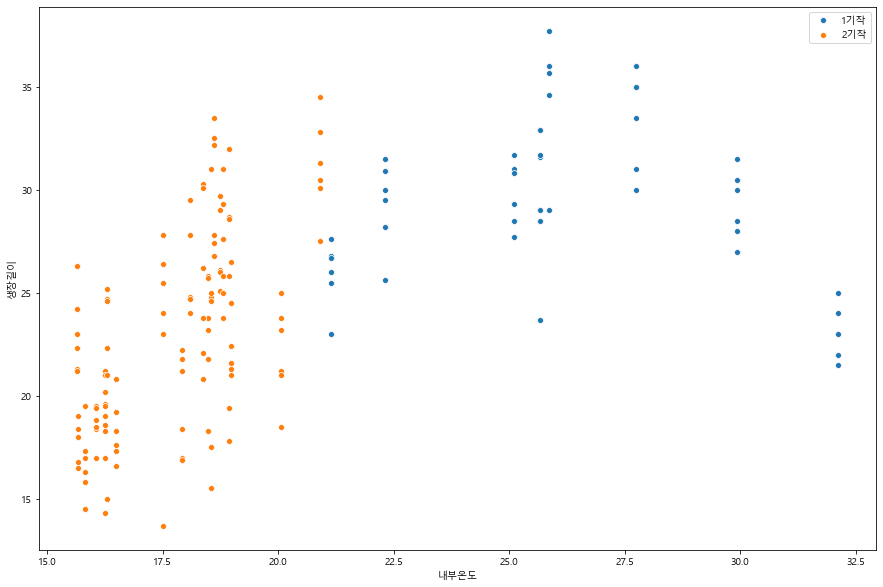

In [36]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=sang_env1, x= "내부온도", y = "생장길이",label='1기작')
sns.scatterplot(data=sang_env2, x= "내부온도", y = "생장길이",label='2기작')

In [37]:
sang_env1[['생장길이','내부온도','내부습도','CO2','일사량']].corr()

,생장길이,내부온도,내부습도,CO2,일사량
생장길이,1.000000,-0.145996,0.594135,0.090271,-0.070351
내부온도,-0.145996,1.000000,-0.525159,-0.873310,0.552838
내부습도,0.594135,-0.525159,1.000000,0.214851,-0.629169
CO2,0.090271,-0.873310,0.214851,1.000000,-0.129807
일사량,-0.070351,0.552838,-0.629169,-0.129807,1.000000


In [38]:
sang_env2[['생장길이','내부온도','내부습도','CO2','일사량']].corr()

,생장길이,내부온도,내부습도,CO2,일사량
생장길이,1.000000,0.612937,-0.271715,-0.523439,0.601351
내부온도,0.612937,1.000000,-0.613547,-0.636524,0.805955
내부습도,-0.271715,-0.613547,1.000000,0.415977,-0.488043
CO2,-0.523439,-0.636524,0.415977,1.000000,-0.391798
일사량,0.601351,0.805955,-0.488043,-0.391798,1.000000


In [39]:
def 다항회귀함수(data,degree,x,y,title,xlab,ylab):
    poly_features = PolynomialFeatures(degree=degree)
    pred_x=np.linspace(16,24,len(data))

    X = np.array(data[x]).reshape(-1,1)
    y = np.array(data[y]).reshape(-1,1)
    X_poly = poly_features.fit_transform(X)
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X_poly,y)
    sort_df=pd.DataFrame({'x':X.flatten(), 
                        'y':lr.predict(X_poly).flatten()}).sort_values('x')

    
    plt.figure(figsize=(15,8))
    plt.scatter(X.flatten(),y.flatten(),s=3, c="black")
    plt.plot(sort_df['x'], sort_df['y'])
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

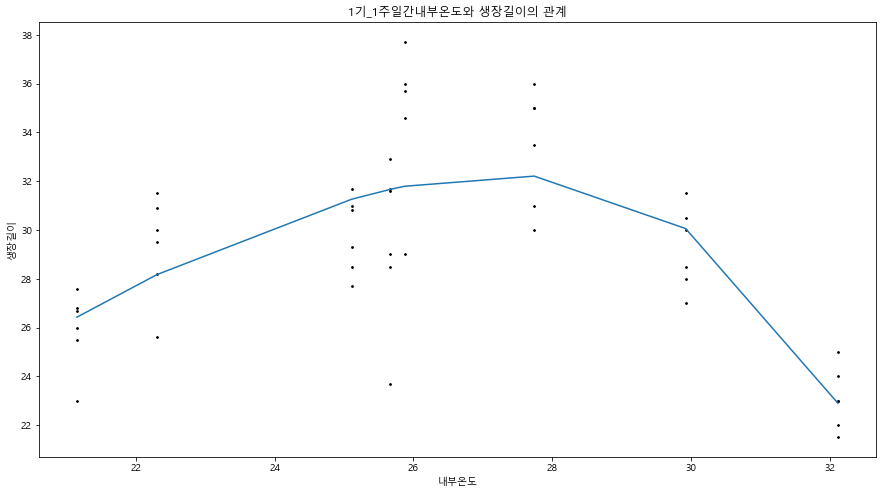

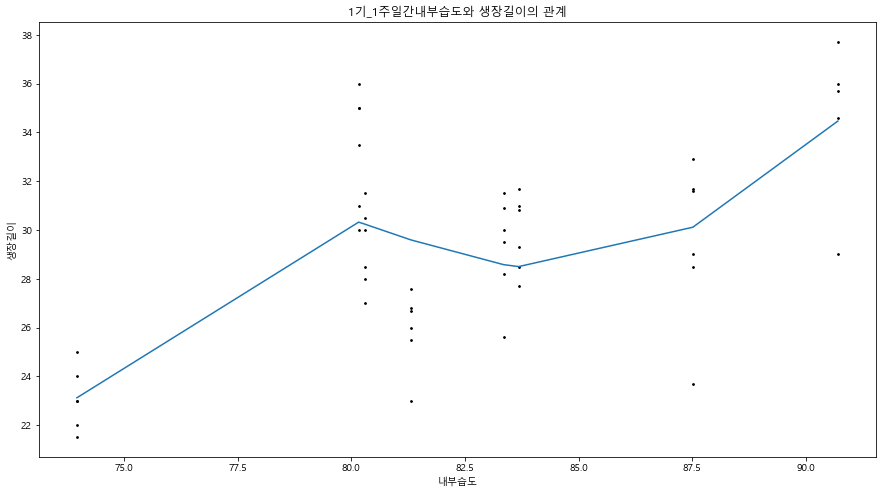

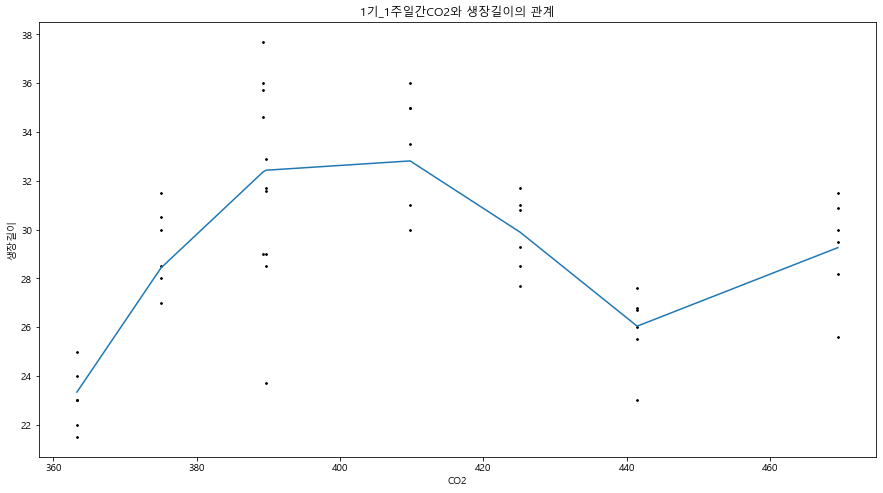

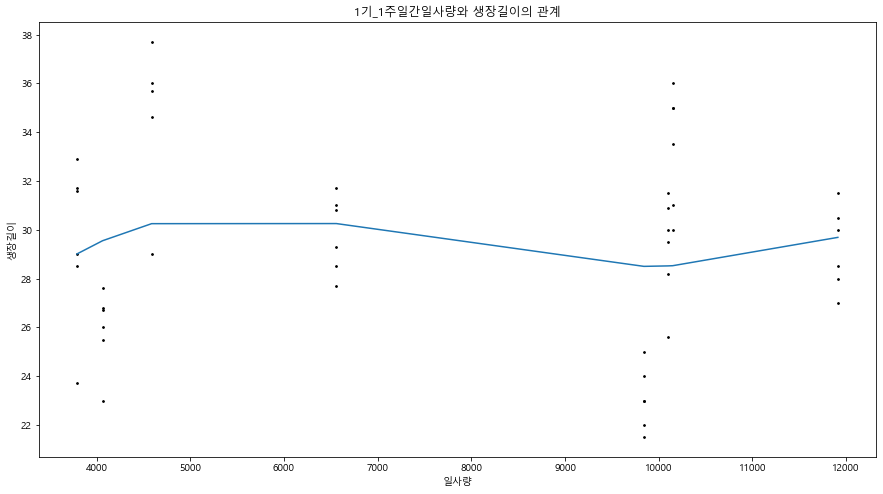

In [40]:
for i in ['내부온도','내부습도','CO2','일사량']:
    다항회귀함수(data = sang_env1,x=i,y='생장길이',degree=4,
          title='1기_1주일간'+i+'와 생장길이의 관계',xlab=i,ylab='생장길이')

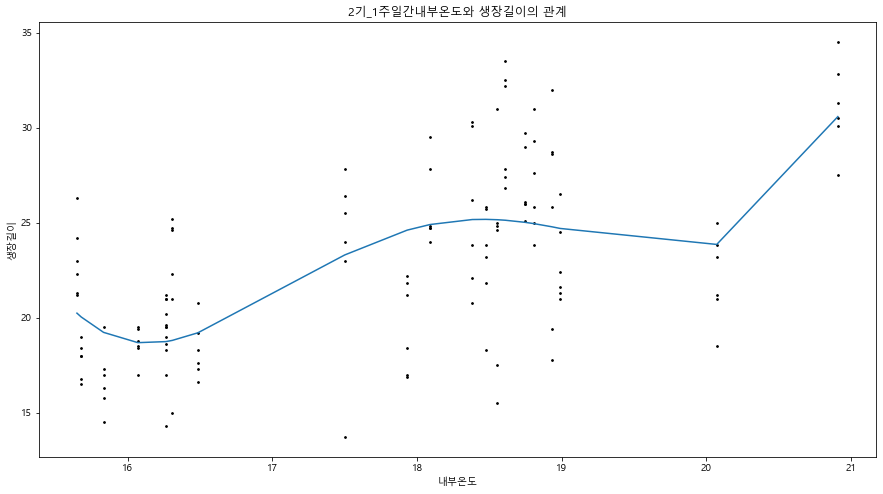

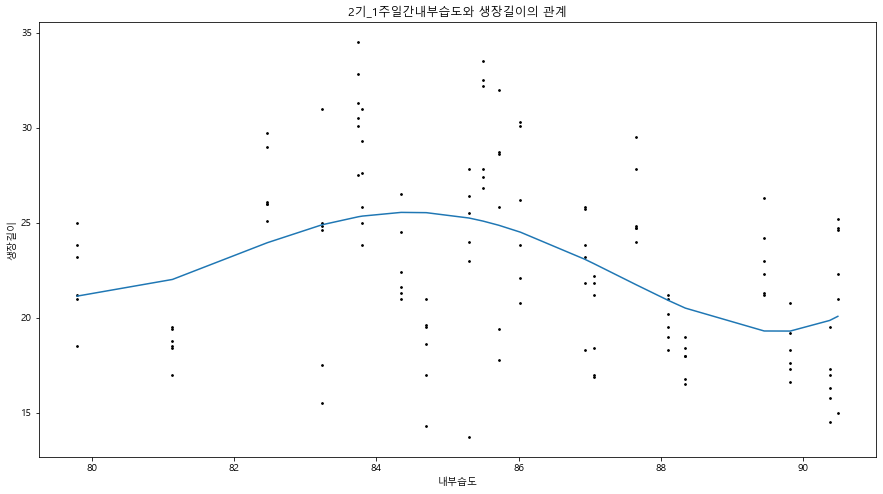

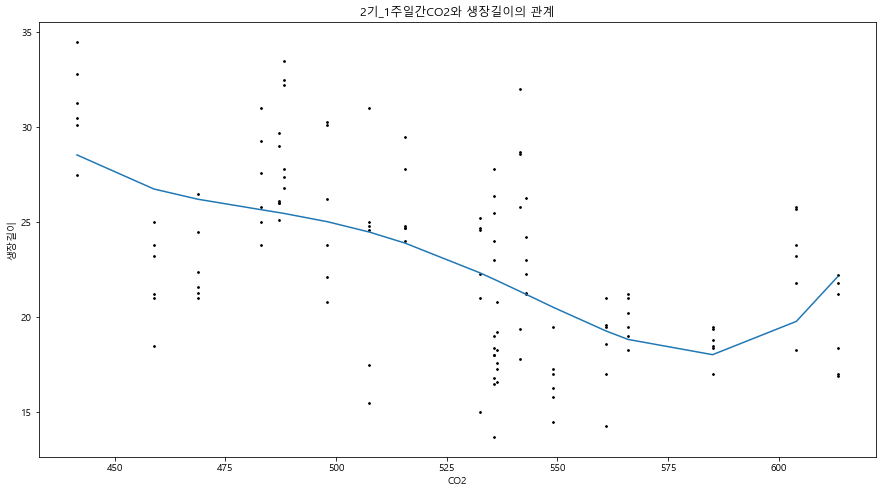

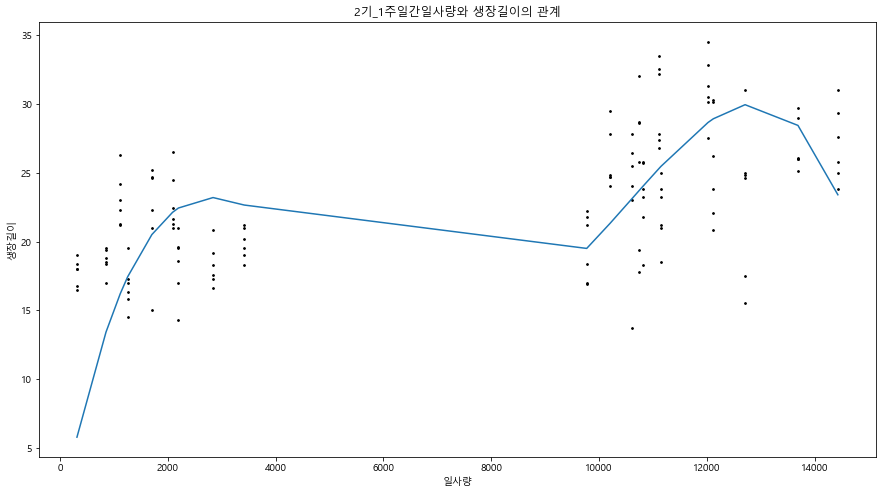

In [41]:
for i in ['내부온도','내부습도','CO2','일사량']:
    다항회귀함수(data = sang_env2,x=i,y='생장길이',degree=4,
          title='2기_1주일간'+i+'와 생장길이의 관계',xlab=i,ylab='생장길이')

# 지연변수 생성(3주)

In [42]:
p=result1
lag_result1=result1
for i in range(3):
    raw_col=p.columns[1:]
    later_df=p.iloc[:,1:].shift(periods=i+1)
    later_col=['_'+str(i+1)+'주전_'+j for j in list(raw_col)]
    later_df.columns=later_col

    lag_result1=pd.concat([lag_result1,later_df],axis=1)

In [43]:
p=result2
lag_result2=result2
for i in range(3):
    raw_col=p.columns[1:]
    later_df=p.iloc[:,1:].shift(periods=i+1)
    later_col=['_'+str(i+1)+'주전_'+j for j in list(raw_col)]
    later_df.columns=later_col

    lag_result2=pd.concat([lag_result2,later_df],axis=1)

In [44]:
lag_result1.head(5)

,주차,내부온도,내부습도,CO2,일사량,_1주전_내부온도,_1주전_내부습도,_1주전_CO2,_1주전_일사량,_2주전_내부온도,_2주전_내부습도,_2주전_CO2,_2주전_일사량,_3주전_내부온도,_3주전_내부습도,_3주전_CO2,_3주전_일사량
0,1,32.113484,73.962384,363.309606,9842.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,29.921131,80.302083,375.036072,11912.0,32.113484,73.962384,363.309606,9842.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,27.740427,80.161706,409.793155,10149.5,29.921131,80.302083,375.036072,11912.0,32.113484,73.962384,363.309606,9842.1,NaN,NaN,NaN,NaN
3,4,25.109201,83.681134,425.112847,6559.8,27.740427,80.161706,409.793155,10149.5,29.921131,80.302083,375.036072,11912.0,32.113484,73.962384,363.309606,9842.1
4,5,25.873094,90.706793,389.284788,4588.0,25.109201,83.681134,425.112847,6559.8,27.740427,80.161706,409.793155,10149.5,29.921131,80.302083,375.036072,11912.0


In [45]:
lag_result2.head(5)

,주차,내부온도,내부습도,CO2,일사량,_1주전_내부온도,_1주전_내부습도,_1주전_CO2,_1주전_일사량,_2주전_내부온도,_2주전_내부습도,_2주전_CO2,_2주전_일사량,_3주전_내부온도,_3주전_내부습도,_3주전_CO2,_3주전_일사량
0,1,16.069524,81.131308,585.065476,852.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,16.262437,84.701460,560.892857,2196.2,16.069524,81.131308,585.065476,852.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,15.677447,88.345107,535.620398,313.0,16.262437,84.701460,560.892857,2196.2,16.069524,81.131308,585.065476,852.2,NaN,NaN,NaN,NaN
3,4,16.264774,88.101498,565.979663,3417.4,15.677447,88.345107,535.620398,313.0,16.262437,84.701460,560.892857,2196.2,16.069524,81.131308,585.065476,852.2
4,5,15.647929,89.454089,542.855035,1116.3,16.264774,88.101498,565.979663,3417.4,15.677447,88.345107,535.620398,313.0,16.262437,84.701460,560.892857,2196.2


# 양액 데이터

In [46]:
yang_data = yang_data[['date','Irrigation (dripper) [ml]','Number of irrigation starts based on radiation sum','Total number of irrigation starts']]

In [47]:
yang_data['n_date']=yang_data['date'].apply(lambda x : x.strftime('%Y-%m-%d'))

In [48]:
def n_date(d):
    myDatetimeStr = d
    myDatetime = datetime.strptime(myDatetimeStr, '%Y-%m-%d')
    return myDatetime

In [49]:
yang_data['date']=yang_data['n_date'].apply(n_date)
del yang_data['n_date']

In [50]:
g_yang_data=yang_data.groupby(['date'])['Number of irrigation starts based on radiation sum','Total number of irrigation starts'].agg('max').reset_index()
g_yang_data.head(5)

,date,Number of irrigation starts based on radiation sum,Total number of irrigation starts
0,2019-07-23,43,71
1,2019-07-24,16,19
2,2019-07-25,16,19
3,2019-07-26,9,12
4,2019-07-27,5,12


In [51]:
def biger(df):
    if df['Number of irrigation starts based on radiation sum']>=df['Total number of irrigation starts']:
        return df['Number of irrigation starts based on radiation sum']
    else:
        return df['Total number of irrigation starts']
g_yang_data['big']=g_yang_data.apply(biger,axis=1)

In [52]:
g_yang_data['tot_yang']=g_yang_data['big']*70.9

In [53]:
del g_yang_data['Number of irrigation starts based on radiation sum']
del g_yang_data['Total number of irrigation starts']
del g_yang_data['big']

In [54]:
g_yang_data.head(5)

,date,tot_yang
0,2019-07-23,5033.9
1,2019-07-24,1347.1
2,2019-07-25,1347.1
3,2019-07-26,850.8
4,2019-07-27,850.8


In [55]:
# 생육 Date와 환경 Date 매칭
def match_test_weeknum(sang_data,g_yang_data):
    dic=dict(zip(sang_data['Date'],sang_data['주차']))
    result=g_yang_data.replace({"date":dic})["date"]
    return result

In [56]:
# 양액 데이터에 주차 컬럼 추가
g_yang_data['주차1']=match_test_weeknum(sang_data1,g_yang_data)
g_yang_data['주차2']=match_test_weeknum(sang_data2,g_yang_data)

In [57]:
d1=sang_data1['Date'].max().strftime('%Y-%m-%d')
d2=sang_data2['Date'].max().strftime('%Y-%m-%d')

In [58]:
start_idx1=g_yang_data[g_yang_data['주차1']==0].index
start_idx2=g_yang_data[g_yang_data['주차2']==0].index

In [59]:
end_idx1=g_yang_data[g_yang_data['date']==datetime.strptime(d1,'%Y-%m-%d')].index
end_idx2=g_yang_data[g_yang_data['date']==datetime.strptime(d2,'%Y-%m-%d')].index

In [60]:
yang_data1=g_yang_data.iloc[start_idx1[0]:end_idx1[0],:]
yang_data2=g_yang_data.iloc[start_idx2[0]:end_idx2[0],:]


In [61]:
del yang_data1['주차2']
del yang_data2['주차1']

In [62]:
yang_data1=yang_data1[['date', '주차1', 'tot_yang']]
yang_data2=yang_data2[['date', '주차2', 'tot_yang']]

In [63]:
yang_data1.head(8)

,date,주차1,tot_yang
15,2019-08-07,0,212.7
16,2019-08-08,2019-08-08 00:00:00,212.7
17,2019-08-09,2019-08-09 00:00:00,354.5
18,2019-08-10,2019-08-10 00:00:00,425.4
19,2019-08-11,2019-08-11 00:00:00,425.4
20,2019-08-12,2019-08-12 00:00:00,425.4
21,2019-08-13,1,425.4
22,2019-08-14,2019-08-14 00:00:00,425.4


In [64]:
yang_data2.head(8)

,date,주차2,tot_yang
153,2019-12-23,0,283.6
154,2019-12-24,2019-12-24 00:00:00,354.5
155,2019-12-25,2019-12-25 00:00:00,425.4
156,2019-12-26,2019-12-26 00:00:00,70.9
157,2019-12-27,2019-12-27 00:00:00,354.5
158,2019-12-28,2019-12-28 00:00:00,354.5
159,2019-12-29,2019-12-29 00:00:00,354.5
160,2019-12-30,1,141.8


# 주차 추가  (사이 채우기)

In [65]:
for i in range(len(yang_data1)):
    if type(yang_data1['주차1'].iloc[i])==int:
        k=yang_data1['주차1'].iloc[i]
    else:
        yang_data1['주차1'].iloc[i]=k
yang_data1=yang_data1.reset_index(drop=True)
yang_data1['주차1']=yang_data1['주차1']+1

In [66]:
for i in range(len(yang_data2)):
    if type(yang_data2['주차2'].iloc[i])==int:
        k=yang_data2['주차2'].iloc[i]
    else:
        yang_data2['주차2'].iloc[i]=k
yang_data2=yang_data2.reset_index(drop=True)
yang_data2['주차2']=yang_data2['주차2']+1

In [67]:
yang_data1.head(8)

,date,주차1,tot_yang
0,2019-08-07,1,212.7
1,2019-08-08,1,212.7
2,2019-08-09,1,354.5
3,2019-08-10,1,425.4
4,2019-08-11,1,425.4
5,2019-08-12,1,425.4
6,2019-08-13,2,425.4
7,2019-08-14,2,425.4


In [68]:
yang_data2.head(8)

,date,주차2,tot_yang
0,2019-12-23,1,283.6
1,2019-12-24,1,354.5
2,2019-12-25,1,425.4
3,2019-12-26,1,70.9
4,2019-12-27,1,354.5
5,2019-12-28,1,354.5
6,2019-12-29,1,354.5
7,2019-12-30,2,141.8


In [69]:
yang_data1_pivot1=yang_data1.pivot_table(index='주차1',values='tot_yang',aggfunc='sum').reset_index()
yang_data2_pivot2=yang_data2.pivot_table(index='주차2',values='tot_yang',aggfunc='sum').reset_index()

In [70]:
yang_data1_pivot1['주차1']=yang_data1_pivot1['주차1'].astype(str)
yang_data2_pivot2['주차2']=yang_data2_pivot2['주차2'].astype(str)

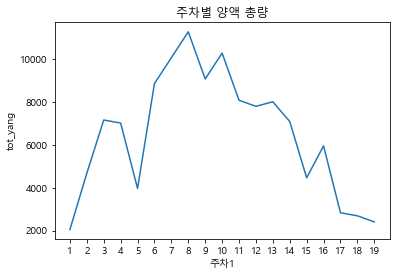

In [71]:
ax=plt.subplot(1,1,1)
sns.lineplot(data=yang_data1_pivot1,x='주차1',y='tot_yang',sort=False)
ax.set_xticklabels(yang_data1_pivot1['주차1'].unique())
plt.title('주차별 양액 총량')
plt.show()

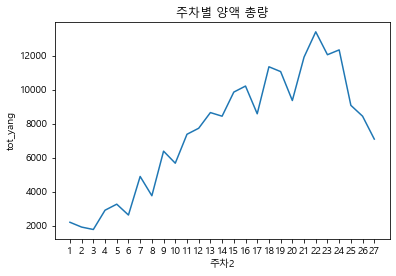

In [72]:
ax=plt.subplot(1,1,1)
sns.lineplot(data=yang_data2_pivot2,x='주차2',y='tot_yang',sort=False)
ax.set_xticklabels(yang_data2_pivot2['주차2'].unique())
plt.title('주차별 양액 총량')

plt.show()

# 지연

In [73]:
p=yang_data1_pivot1
yang_lag_result1=yang_data1_pivot1
for i in range(3):
    raw_col=p.columns[1:]
    later_df=p.iloc[:,1:].shift(periods=i+1)
    later_col=['_'+str(i+1)+'일주_'+j for j in list(raw_col)]
    later_df.columns=later_col

    yang_lag_result1=pd.concat([yang_lag_result1,later_df],axis=1)

In [74]:
yang_lag_result1.head(5)

,주차1,tot_yang,_1일주_tot_yang,_2일주_tot_yang,_3일주_tot_yang
0,1,2056.1,NaN,NaN,NaN
1,2,4679.4,2056.1,NaN,NaN
2,3,7160.9,4679.4,2056.1,NaN
3,4,7019.1,7160.9,4679.4,2056.1
4,5,3970.4,7019.1,7160.9,4679.4


In [75]:
p=yang_data2_pivot2
yang_lag_result2=yang_data2_pivot2
for i in range(3):
    raw_col=p.columns[1:]
    later_df=p.iloc[:,1:].shift(periods=i+1)
    later_col=['_'+str(i+1)+'일주_'+j for j in list(raw_col)]
    later_df.columns=later_col

    yang_lag_result2=pd.concat([yang_lag_result2,later_df],axis=1)

In [76]:
lag_env_yang1=pd.concat([lag_result1,yang_lag_result1],axis=1)
del lag_env_yang1['주차1']

In [77]:
lag_env_yang1.head(5)

,주차,내부온도,내부습도,CO2,일사량,_1주전_내부온도,_1주전_내부습도,_1주전_CO2,_1주전_일사량,_2주전_내부온도,_2주전_내부습도,_2주전_CO2,_2주전_일사량,_3주전_내부온도,_3주전_내부습도,_3주전_CO2,_3주전_일사량,tot_yang,_1일주_tot_yang,_2일주_tot_yang,_3일주_tot_yang
0,1,32.113484,73.962384,363.309606,9842.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2056.1,NaN,NaN,NaN
1,2,29.921131,80.302083,375.036072,11912.0,32.113484,73.962384,363.309606,9842.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4679.4,2056.1,NaN,NaN
2,3,27.740427,80.161706,409.793155,10149.5,29.921131,80.302083,375.036072,11912.0,32.113484,73.962384,363.309606,9842.1,NaN,NaN,NaN,NaN,7160.9,4679.4,2056.1,NaN
3,4,25.109201,83.681134,425.112847,6559.8,27.740427,80.161706,409.793155,10149.5,29.921131,80.302083,375.036072,11912.0,32.113484,73.962384,363.309606,9842.1,7019.1,7160.9,4679.4,2056.1
4,5,25.873094,90.706793,389.284788,4588.0,25.109201,83.681134,425.112847,6559.8,27.740427,80.161706,409.793155,10149.5,29.921131,80.302083,375.036072,11912.0,3970.4,7019.1,7160.9,4679.4


In [78]:
lag_env_yang2=pd.concat([lag_result2,yang_lag_result2],axis=1)
del lag_env_yang2['주차2']

In [79]:
lag_env_yang2.head(5)

,주차,내부온도,내부습도,CO2,일사량,_1주전_내부온도,_1주전_내부습도,_1주전_CO2,_1주전_일사량,_2주전_내부온도,_2주전_내부습도,_2주전_CO2,_2주전_일사량,_3주전_내부온도,_3주전_내부습도,_3주전_CO2,_3주전_일사량,tot_yang,_1일주_tot_yang,_2일주_tot_yang,_3일주_tot_yang
0,1,16.069524,81.131308,585.065476,852.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2197.9,NaN,NaN,NaN
1,2,16.262437,84.701460,560.892857,2196.2,16.069524,81.131308,585.065476,852.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1914.3,2197.9,NaN,NaN
2,3,15.677447,88.345107,535.620398,313.0,16.262437,84.701460,560.892857,2196.2,16.069524,81.131308,585.065476,852.2,NaN,NaN,NaN,NaN,1772.5,1914.3,2197.9,NaN
3,4,16.264774,88.101498,565.979663,3417.4,15.677447,88.345107,535.620398,313.0,16.262437,84.701460,560.892857,2196.2,16.069524,81.131308,585.065476,852.2,2906.9,1772.5,1914.3,2197.9
4,5,15.647929,89.454089,542.855035,1116.3,16.264774,88.101498,565.979663,3417.4,15.677447,88.345107,535.620398,313.0,16.262437,84.701460,560.892857,2196.2,3261.4,2906.9,1772.5,1914.3


# 병합

In [80]:
merge_dataset1 = pd.merge(sang_data1,lag_env_yang1,how='left',on='주차')
merge_dataset_delout1 = pd.merge(sang_data_delout1,lag_env_yang1,how='left',on='주차')

merge_dataset2 = pd.merge(sang_data2,lag_env_yang2,how='left',on='주차')
merge_dataset_delout2 = pd.merge(sang_data_delout2,lag_env_yang2,how='left',on='주차')

In [81]:
dataset1=merge_dataset1.dropna()
dataset_delout1=merge_dataset_delout1.dropna()

dataset2=merge_dataset2.dropna()
dataset_delout2=merge_dataset_delout2.dropna()

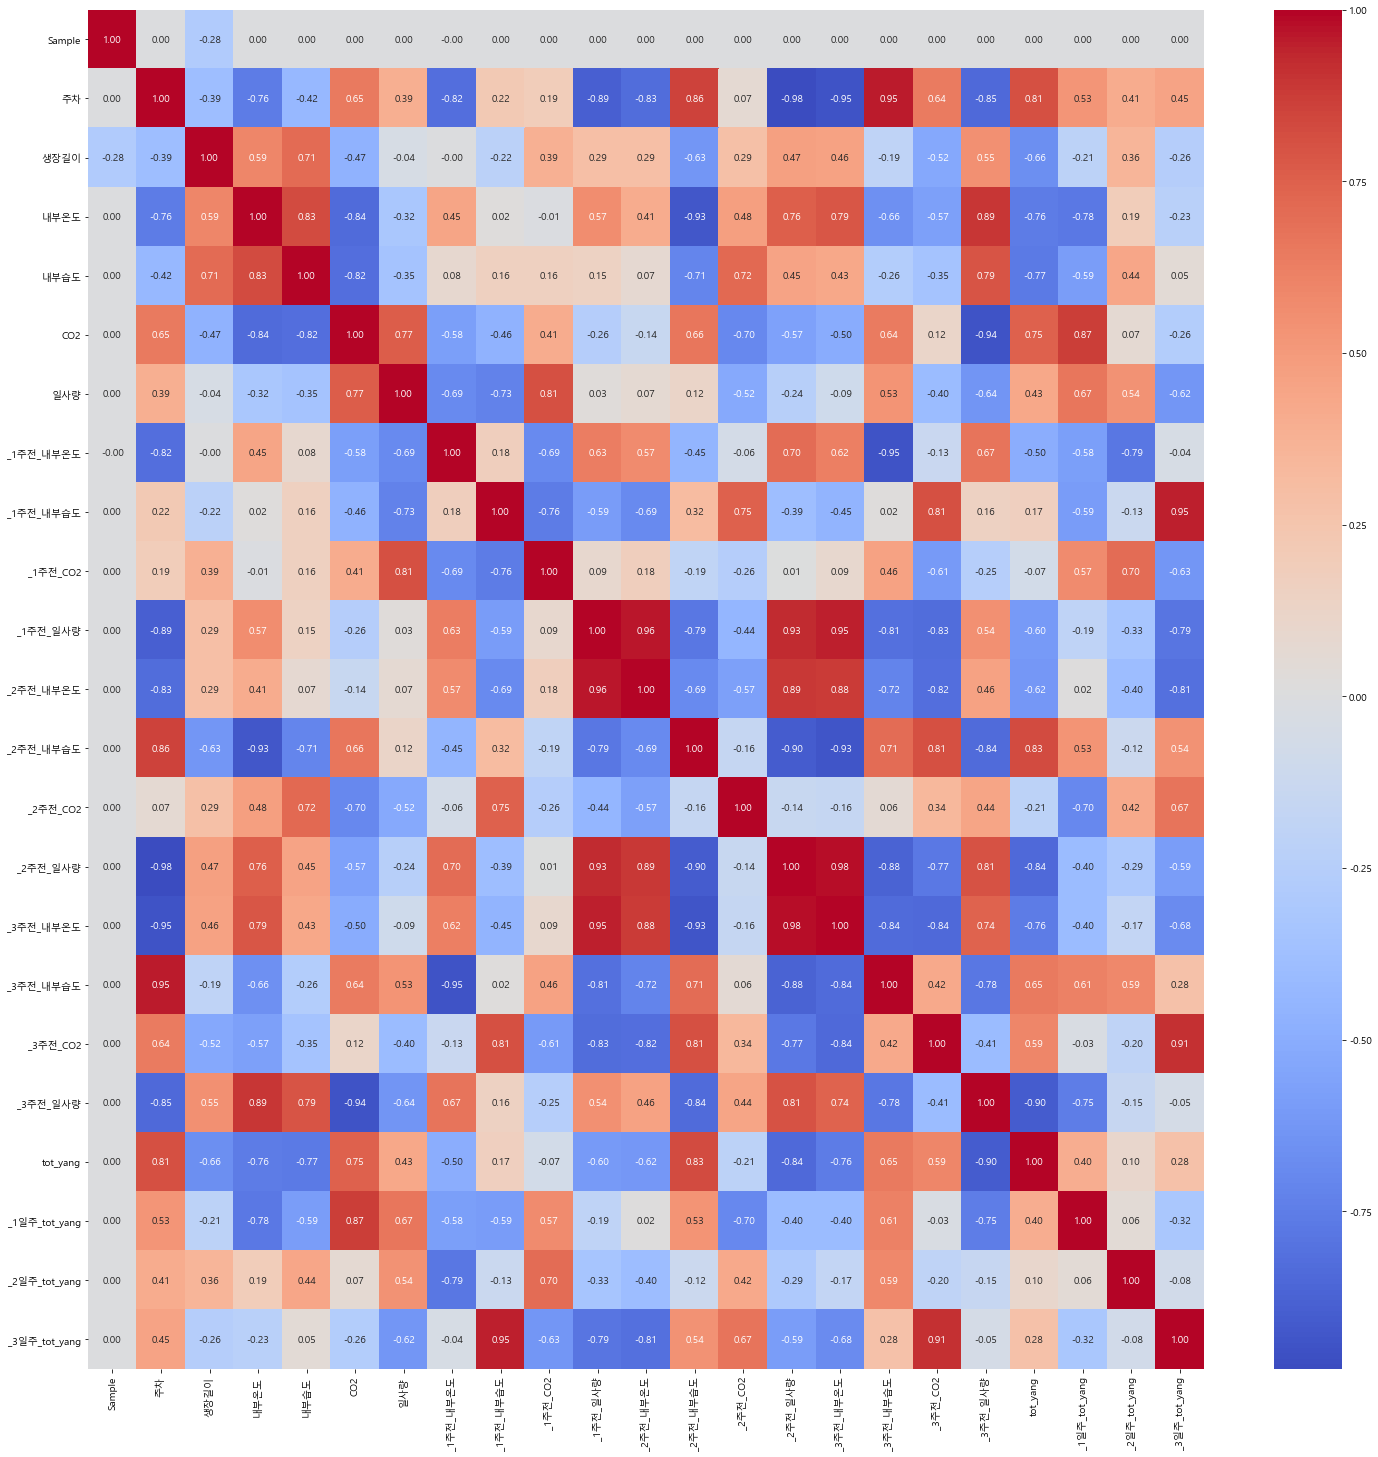

In [82]:
plt.figure(figsize=(25,25))
g = sns.heatmap(dataset1.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

# XGBOOST

In [83]:
from sklearn.datasets import load_boston
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold

In [84]:
def xgb(df,Y,parameters,col):

    test_size=0.25
    
    xgb_model = xgboost.XGBRegressor(n_estimators=100, gamma=0,
                               colsample_bytree=1, max_depth=7)

    
    xgb_regressor = GridSearchCV(xgb_model,parameters,scoring='neg_mean_squared_error',cv=10)

    x_train=df.iloc[:,col]
    y_train=df[Y]
    
    
    
    
    xgb_regressor.fit(x_train,y_train)
    print(xgb_regressor.best_params_)
    
    eta=xgb_regressor.best_params_['eta']
    learning_rate=xgb_regressor.best_params_['learning_rate']
    subsample = xgb_regressor.best_params_['subsample']
    
    # Kfold
    X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size)
    xgb_model = xgboost.XGBRegressor(n_estimators=100,  gamma=0,colsample_bytree=1, max_depth=7,
                                     learning_rate=learning_rate,
                                     subsample=subsample,
                                     eta=eta
                           )

    print(len(X_train), len(X_test))
    
    xgb_model.fit(X_train,y_train)
    predictions = xgb_model.predict(X_test)
    RMSE = mean_squared_error(y_test, predictions)**0.5
    print(RMSE)
    
    
    xgboost.plot_importance(xgb_model)
    
    
    plt.figure(figsize=[18,10])
    sns.lineplot(x=range(len(predictions)),y=predictions,label="pred")
    sns.lineplot(x=range(len(y_test)),y=y_test,label="Test")
    plt.show()
   
    plt.figure(figsize=[24,12])
    sns.lineplot(x=range(len(y_test)),y=y_test-predictions,label="Test")
    plt.title("차이")
    plt.show()
    print("--------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------")
    
    result_df = pd.DataFrame({'y_test':y_test,
                             'pred':predictions,
                             '차이':abs(y_test-predictions)})
    result_df=result_df.sort_values('차이',ascending=False).head(6)
    
    
    return result_df

# 생장길이+환경+양액 3주

In [85]:
model_dataset1=merge_dataset1[['생장길이']+list(merge_dataset1.columns[list(range(4,len(merge_dataset1.columns)))])].dropna()

In [86]:
model_dataset1.head(5)

,생장길이,내부온도,내부습도,CO2,일사량,_1주전_내부온도,_1주전_내부습도,_1주전_CO2,_1주전_일사량,_2주전_내부온도,_2주전_내부습도,_2주전_CO2,_2주전_일사량,_3주전_내부온도,_3주전_내부습도,_3주전_CO2,_3주전_일사량,tot_yang,_1일주_tot_yang,_2일주_tot_yang,_3일주_tot_yang
24,31.0,25.109201,83.681134,425.112847,6559.8,27.740427,80.161706,409.793155,10149.5,29.921131,80.302083,375.036072,11912.0,32.113484,73.962384,363.309606,9842.1,7019.1,7160.9,4679.4,2056.1
25,28.5,25.109201,83.681134,425.112847,6559.8,27.740427,80.161706,409.793155,10149.5,29.921131,80.302083,375.036072,11912.0,32.113484,73.962384,363.309606,9842.1,7019.1,7160.9,4679.4,2056.1
26,31.7,25.109201,83.681134,425.112847,6559.8,27.740427,80.161706,409.793155,10149.5,29.921131,80.302083,375.036072,11912.0,32.113484,73.962384,363.309606,9842.1,7019.1,7160.9,4679.4,2056.1
27,29.3,25.109201,83.681134,425.112847,6559.8,27.740427,80.161706,409.793155,10149.5,29.921131,80.302083,375.036072,11912.0,32.113484,73.962384,363.309606,9842.1,7019.1,7160.9,4679.4,2056.1
28,27.7,25.109201,83.681134,425.112847,6559.8,27.740427,80.161706,409.793155,10149.5,29.921131,80.302083,375.036072,11912.0,32.113484,73.962384,363.309606,9842.1,7019.1,7160.9,4679.4,2056.1


{'eta': 0.001, 'learning_rate': 0.13, 'subsample': 0.86}
22 8
3.3086744313408727


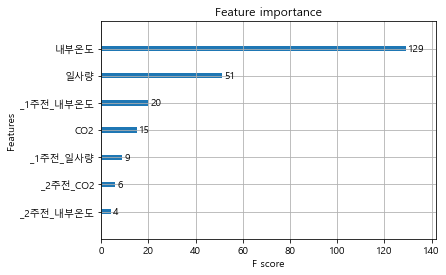

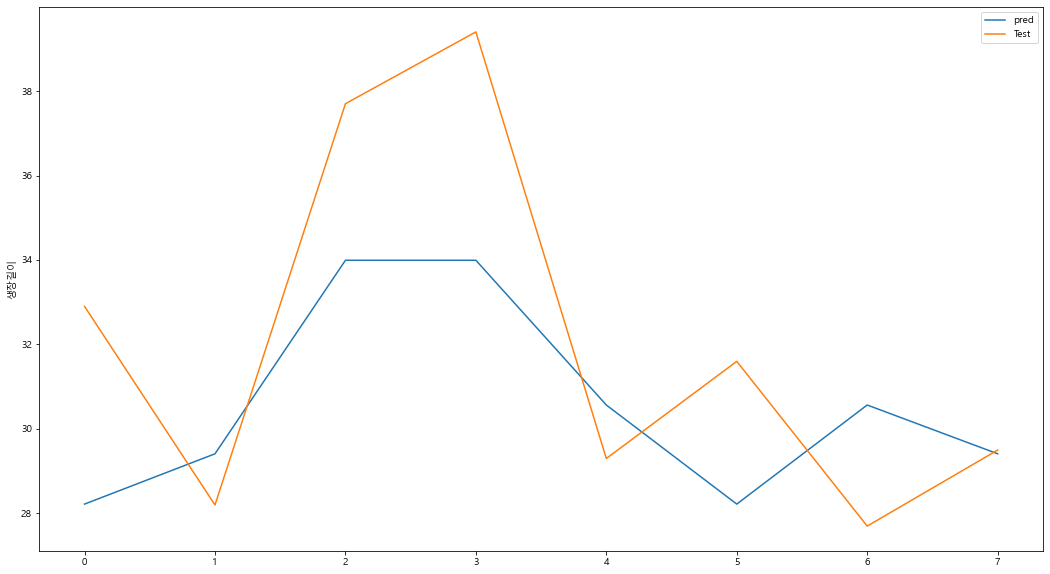

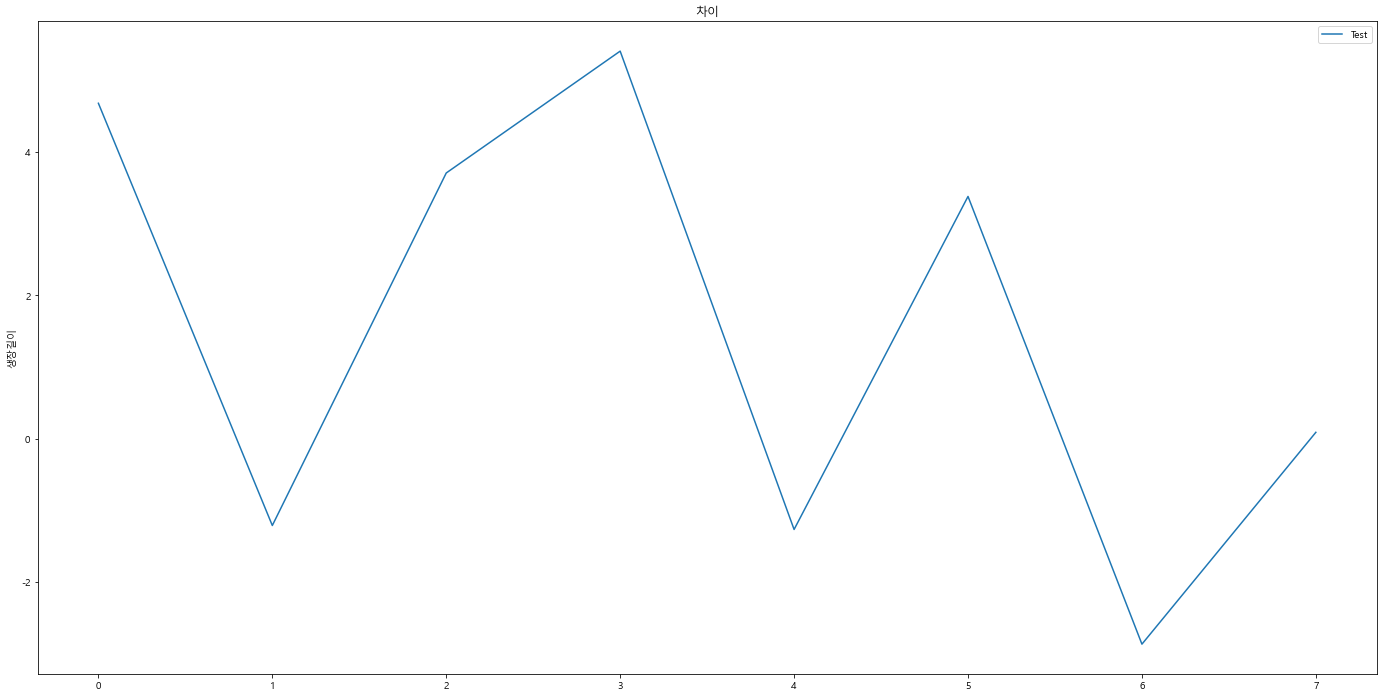

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


,Date,Sample,주차,생장길이,내부온도,내부습도,CO2,일사량,_1주전_내부온도,_1주전_내부습도,_1주전_CO2,_1주전_일사량,_2주전_내부온도,_2주전_내부습도,_2주전_CO2,_2주전_일사량,_3주전_내부온도,_3주전_내부습도,_3주전_CO2,_3주전_일사량,tot_yang,_1일주_tot_yang,_2일주_tot_yang,_3일주_tot_yang
33,2019-09-09,4,5,39.4,25.873094,90.706793,389.284788,4588.0,25.109201,83.681134,425.112847,6559.8,27.740427,80.161706,409.793155,10149.5,29.921131,80.302083,375.036072,11912.0,3970.4,7019.1,7160.9,4679.4
38,2019-09-16,3,6,32.9,25.667758,87.516195,389.678028,3791.2,25.873094,90.706793,389.284788,4588.0,25.109201,83.681134,425.112847,6559.8,27.740427,80.161706,409.793155,10149.5,8862.5,3970.4,7019.1,7160.9
30,2019-09-09,1,5,37.7,25.873094,90.706793,389.284788,4588.0,25.109201,83.681134,425.112847,6559.8,27.740427,80.161706,409.793155,10149.5,29.921131,80.302083,375.036072,11912.0,3970.4,7019.1,7160.9,4679.4
37,2019-09-16,2,6,31.6,25.667758,87.516195,389.678028,3791.2,25.873094,90.706793,389.284788,4588.0,25.109201,83.681134,425.112847,6559.8,27.740427,80.161706,409.793155,10149.5,8862.5,3970.4,7019.1,7160.9
28,2019-09-02,5,4,27.7,25.109201,83.681134,425.112847,6559.8,27.740427,80.161706,409.793155,10149.5,29.921131,80.302083,375.036072,11912.0,32.113484,73.962384,363.309606,9842.1,7019.1,7160.9,4679.4,2056.1
27,2019-09-02,4,4,29.3,25.109201,83.681134,425.112847,6559.8,27.740427,80.161706,409.793155,10149.5,29.921131,80.302083,375.036072,11912.0,32.113484,73.962384,363.309606,9842.1,7019.1,7160.9,4679.4,2056.1


In [88]:
parameters = {'eta':[0.001,0.005,0.01],
              'learning_rate':[0.13,0.15,0.17],
              'subsample':[0.85,0.86,0.9]}
col=list(range(1,len(model_dataset1.columns)))


result = xgb(model_dataset1,'생장길이',parameters=parameters,col=col)
merge_dataset1.iloc[result.index,:]

In [ ]:
xgb(dataset,y,plot='no')

In [ ]:
xgb(dataset,y,plot='no')

In [ ]:
xgb(dataset,y,plot='no')

In [ ]:
xgb(dataset,y,plot='no')

In [ ]:
xgb(dataset,y,plot='no')

In [ ]:
y='생장길이'
dataset_delout['주차']=pd.to_numeric(dataset_delout['주차'])

In [ ]:
xgb(dataset_delout,y,plot='no')

In [ ]:
xgb(dataset_delout,y,plot='no')

In [ ]:
xgb(dataset_delout,y,plot='no')

In [ ]:
xgb(dataset_delout,y,plot='no')

In [ ]:
xgb(dataset_delout,y,plot='no')

In [ ]:
xgb(dataset_delout,y,plot='no')

----
----
----
----
----
----
----
----

In [ ]:
# 화방

----

# 수확과

# 1기작 ------------------------------------------------------------

# 표본별로 수확된 과일의 개수가 차이가 있는가?

![분산분석로드맵](https://user-images.githubusercontent.com/34879309/98882835-82baa680-24d0-11eb-9c1e-3b338e719dba.PNG)

출처 :statedu.com

In [89]:
harvest_cnt = harvest_data1[['날짜','샘플','과중(g)']].pivot_table(index=['날짜','샘플'],values='과중(g)',aggfunc='count').reset_index()
harvest_cnt.columns=['날짜','샘플','개수']
harvest_cnt.head(7)

,날짜,샘플,개수
0,2019-09-16,1,17
1,2019-09-16,2,15
2,2019-09-16,3,11
3,2019-09-16,4,12
4,2019-09-16,5,13
5,2019-09-16,6,13
6,2019-09-23,1,11


In [90]:
harvest_cnt['날짜']=harvest_cnt['날짜'].astype(str)
harvest_cnt['샘플']=harvest_cnt['샘플'].astype(str)

In [91]:
x1 = np.array(harvest_cnt[harvest_cnt['샘플'] == '1']['개수'])
x2 = np.array(harvest_cnt[harvest_cnt['샘플'] == '2']['개수'])
x3 = np.array(harvest_cnt[harvest_cnt['샘플'] == '3']['개수'])
x4 = np.array(harvest_cnt[harvest_cnt['샘플'] == '4']['개수'])
x5 = np.array(harvest_cnt[harvest_cnt['샘플'] == '5']['개수'])
x6 = np.array(harvest_cnt[harvest_cnt['샘플'] == '6']['개수'])

In [92]:
from scipy import stats
# 등분산 검정
print(stats.bartlett(x1,x2,x3,x4,x5,x6),stats.fligner(x1, x2, x3,x4,x5,x6) ,stats.levene(x1, x2, x3,x4,x5,x6), sep="\n")

BartlettResult(statistic=12.410693296548976, pvalue=0.029573703625364857)
FlignerResult(statistic=9.581999812548057, pvalue=0.08798341747706061)
LeveneResult(statistic=1.4576565291142891, pvalue=0.21367440476068011)


등분산성을 모두 만족한다.

In [93]:
# 정규성 검정
print(stats.shapiro(x1))
print(stats.shapiro(x2))
print(stats.shapiro(x3))
print(stats.shapiro(x4))
print(stats.shapiro(x5))
print(stats.shapiro(x6))

ShapiroResult(statistic=0.9521911144256592, pvalue=0.5952141880989075)
ShapiroResult(statistic=0.9305466413497925, pvalue=0.3105728030204773)
ShapiroResult(statistic=0.9420267343521118, pvalue=0.4449101686477661)
ShapiroResult(statistic=0.8135126829147339, pvalue=0.007369167171418667)
ShapiroResult(statistic=0.8711588382720947, pvalue=0.05420687794685364)
ShapiroResult(statistic=0.9361310005187988, pvalue=0.40879037976264954)


1,2,3,5는 정규분포이지만 4,6은 정규성을 만족하지 못한다.
분포를 살펴보자

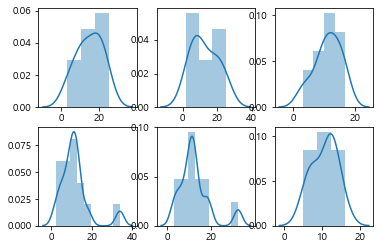

In [94]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
sns.distplot(x1, ax=ax1)
sns.distplot(x2, ax=ax2)
sns.distplot(x3, ax=ax3)
sns.distplot(x4, ax=ax4)
sns.distplot(x5, ax=ax5)
sns.distplot(x6, ax=ax6)


## 우선 정규+등분산을 만족하는 1,2,3,5 그룹만 onewaytest

In [95]:
stats.f_oneway(x1,x2,x3,x4)

F_onewayResult(statistic=0.8452237969413091, pvalue=0.4754159096634746)

갯수의 차이가 없다고 볼 수 있다.

## 정규를 만족하지 않는 그룹이 하나라도 있을 때

In [96]:
stats.kruskal(x1, x2, x3,x4,x5,x6)

KruskalResult(statistic=3.8109521977781613, pvalue=0.5769425871102414)

크게 그룹(샘플번호)간 개수의 차이를 보이지는 않는다.

In [97]:
import scikit_posthocs as sp

In [98]:
# 위에서 그룹간 차이를 보이지 않았지만 사후검정을 해보았다.
sp.posthoc_conover(harvest_cnt,
                  val_col = '개수',
                  group_col = '샘플',
                  p_adjust = 'holm')

,1,2,3,4,5,6
1,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0


# 화방별로 수확과 개수 차이가 있는가?

In [106]:
harvest_cnt = harvest_data1[['샘플','날짜','화방','과중(g)']].pivot_table(index=['샘플','화방'],values='과중(g)',aggfunc='count').reset_index()
harvest_cnt.columns=['샘플','화방','개수']
harvest_cnt['화방']=harvest_cnt['화방'].astype(str)
harvest_cnt

,샘플,화방,개수
0,1,1,12
1,1,2,26
2,1,3,18
3,1,4,28
4,1,5,30
5,1,6,21
6,1,7,21
7,1,8,10
8,1,9,17
9,1,10,16


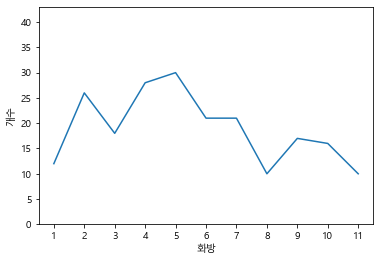

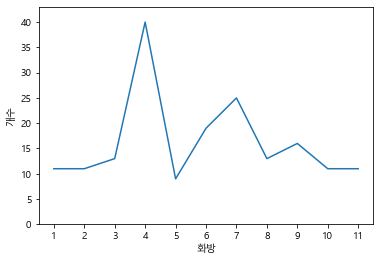

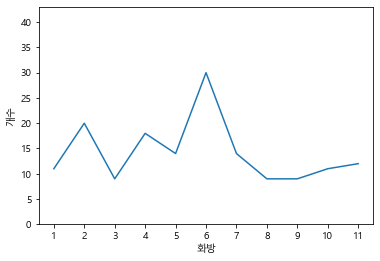

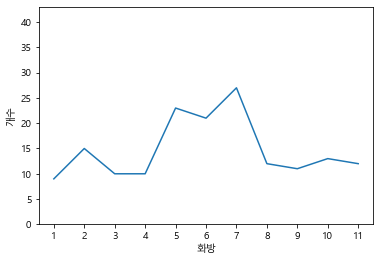

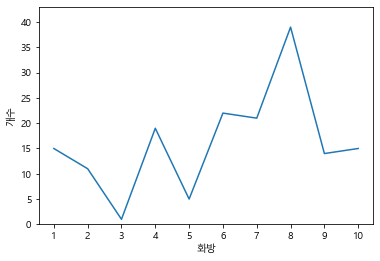

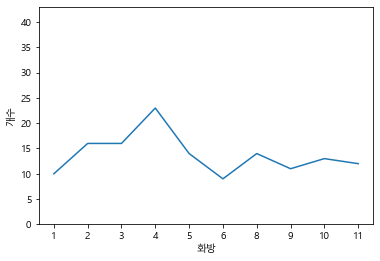

In [111]:
for i in range(6):
    df = harvest_cnt[harvest_cnt['샘플']==i+1]
    ax = plt.subplot(1,1,1)
    sns.lineplot(df['화방'],df['개수'],sort=False)
    ax.set_xticklabels(df['화방'])
    plt.ylim([0,max(harvest_cnt['개수'])+3])
    plt.show()

# 샘플별로 수확과의 무게 차이가 있는가?

In [101]:
harvest_weight = harvest_data1[['날짜','화방','샘플','과중(g)']]

In [102]:
harvest_weight.head(4)

,날짜,화방,샘플,과중(g)
0,2019-09-16,1,1,4.00
1,2019-09-16,1,1,15.20
2,2019-09-16,1,1,13.62
3,2019-09-16,1,1,7.71


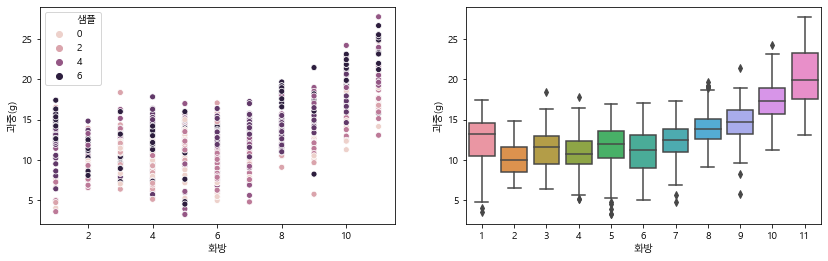

In [114]:

fig, ((ax1,ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(14,4))

sns.scatterplot(data=harvest_weight, x = '화방',y='과중(g)',hue='샘플',ax=ax1)
sns.boxplot(data=harvest_weight, x = '화방',y='과중(g)',ax=ax2)

In [117]:
harvest_filter=harvest_data1[['날짜','주차','샘플','화방','수확번호','과중(g)']]

In [118]:
harvest_filter.head(5)

,날짜,주차,샘플,화방,수확번호,과중(g)
0,2019-09-16,38,1,1,1,4.00
1,2019-09-16,38,1,1,2,15.20
2,2019-09-16,38,1,1,3,13.62
3,2019-09-16,38,1,1,4,7.71
4,2019-09-16,38,1,1,5,7.63


In [122]:
harvest_filter.pivot_table(index=['날짜','주차','샘플','화방'],values='수확번호',aggfunc='count').reset_index()

,날짜,주차,샘플,화방,수확번호
0,2019-09-16,38,1,1,12
1,2019-09-16,38,1,2,5
2,2019-09-16,38,2,1,10
3,2019-09-16,38,2,2,5
4,2019-09-16,38,3,1,9
5,2019-09-16,38,3,2,2
6,2019-09-16,38,4,1,9
7,2019-09-16,38,4,2,3
8,2019-09-16,38,5,1,13
9,2019-09-16,38,6,1,10
